In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
import qiskit.quantum_info as qi
# Tomography functions
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import DensityMatrix

from qiskit import *
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import *

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

In [2]:
#Create cat states
n = 5
vectors = []
circuits = []
for i in range(2, n + 1):
    cir = QuantumCircuit(i)
    cir.h(0)
    for j in range(0, i - 1):
        cir.cx(j, j + 1)
    circuits.append(cir)
    vectors.append(qi.Statevector.from_instruction(cir))
drawings = []
for i in range(len(circuits)):
    drawings.append(circuits[i].draw(output='mpl'))

In [3]:
tomo_circuits = []
vectors = []

for cir in circuits:
    vectors.append(qi.Statevector.from_instruction(cir))
    tomo_circuits.append(state_tomography_circuits(cir, cir.qubits));

/home/david/python-inter/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/home/david/python-inter/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/home/david/python-inter/lib/python3.9/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/home/davi

In [ ]:
#Simulator
name = 'ibm_lagos'
results = []
backend = provider.get_backend(name)
noise_model = NoiseModel.from_backend(backend)
full_layout = [0, 1, 3, 5, 4, 2, 6]
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
qcomp = Aer.get_backend("qasm_simulator")
for group in tomo_circuits:
    layout = full_layout[:group[0].num_qubits]
    results.append(qiskit.execute(group, Aer.get_backend('qasm_simulator'),
                                  coupling_map=coupling_map,
                                  basis_gates=basis_gates,
                                  noise_model=noise_model, initial_layout=layout, shots=8000).result())

In [4]:
#Retriev
#Retrive results:
import utility
results = [utility.retrieve("Lagos_fidelity_to_qubits_withMap_(1)").result(),
           utility.retrieve("Lagos_fidelity_to_qubits_withMap_(1)0").result(),
           utility.retrieve("Lagos_fidelity_to_qubits_withMap_(1)1").result(),
           utility.retrieve("Lagos_fidelity_to_qubits_withMap_(1)2").result()]


/home/david/python-inter/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Retrieved from memory
Retrieved from memory
Retrieved from memory
Retrieved from memory


In [5]:
from Tomography import tomography

densities = []
fidelities = {}
purities = {}
for i in range(len(results)):
    tomo_fitter_bell = StateTomographyFitter(results[i], tomo_circuits[i]).fit(method='lstsq')
    densities.append(DensityMatrix(tomo_fitter_bell))
    temp_dict = {i + 2: (tomography.calc_fidelity(DensityMatrix(tomo_fitter_bell), vectors[i]))}
    temp_dict_pure = {i + 2: (tomography.calc_purity(DensityMatrix(tomo_fitter_bell)))}
    fidelities.update(temp_dict)
    purities.update(temp_dict_pure)
print(fidelities)


{2: 0.9091983025245381, 3: 0.857447271135891, 4: 0.8090960033984691, 5: 0.6525253675155589}


In [6]:
# Theoretical Vector
from IPython.display import display, Latex
from numpy.linalg import linalg

fixed_purities = []
#qubits
for k in range(2,6):
    # Extracting the density matrix from the state tomography result
    state_vector = qi.Statevector.from_instruction(circuits[k - 2])
    theo_matrix = DensityMatrix(state_vector)
    theo_eig = linalg.eig(theo_matrix.data)
    theo_eig = (theo_eig[0], theo_eig[1].T)

    # Getting the most significant eigenvalue and eigenvector
    max_val_theo = 0
    index = 0
    i = 0
    for val in theo_eig[0]:
        if np.absolute(val) > np.absolute(max_val_theo):
            index = i
            max_val_theo = val
        i += 1
    theo_vector = theo_eig[1][index]

    # Real Vector
    real_matrix = densities[k - 2]
    real_eig = np.linalg.eig(real_matrix)
    real_eig = (real_eig[0], real_eig[1].T)

    # Getting the most significant eigenvalue and eigenvector
    max_val_real = 0
    index = 0
    i = 0
    for val in real_eig[0]:
        if np.absolute(val) > np.absolute(max_val_real):
            index = i
            max_val_real = val
        i += 1
    real_vector = real_eig[1][index]
    real_eignval = real_eig[0][index]


    dot = np.abs(np.vdot(theo_vector, real_vector))**2
    print("Number of qubits: ", k)
    print("Vector dot: ", dot)
    print("Eigenvalue", real_eignval)
    print("Purity: ", np.absolute(purities[k]))
    print("Fidelity: ", np.absolute(fidelities[k]))

    print("___")
    fixed_purities.append(np.absolute(purities[k]) * (dot**2))
    print("Fixed purity: ", fixed_purities[-1])
    print("_____________")
    

Number of qubits:  2
Vector dot:  0.9986676054164955
Eigenvalue (0.954769667743505-2.9541087139193175e-18j)
Purity:  0.912992621352396
Fidelity:  0.9091983025245381
___
Fixed purity:  0.9105613093187306
_____________
Number of qubits:  3
Vector dot:  0.9853282292753108
Eigenvalue (0.9396071538120738-4.218170344133135e-19j)
Purity:  0.8851537495528895
Fidelity:  0.857447271135891
___
Fixed purity:  0.8593707427678071
_____________
Number of qubits:  4
Vector dot:  0.9846273543171584
Eigenvalue (0.9132748140122333+1.1474414959865144e-17j)
Purity:  0.8371302737671684
Fidelity:  0.8090960033984691
___
Fixed purity:  0.8115902887381673
_____________
Number of qubits:  5
Vector dot:  0.8986327235075094
Eigenvalue (0.89407292467052-4.906210668364159e-18j)
Purity:  0.8024920466953208
Fidelity:  0.6525253675155589
___
Fixed purity:  0.6480450467184168
_____________


{2: 0.9091983025245381, 3: 0.857447271135891, 4: 0.8090960033984691, 5: 0.6525253675155589}
{2: (0.912992621352396+0j), 3: (0.8851537495528895+8.475798129749539e-19j), 4: (0.8371302737671684+1.2354406933279193e-18j), 5: (0.8024920466953208-3.828631322118957e-18j)}
 
-0.08184 x + 1.093
 
(-0.03795 + -1.11e-18j) x + (0.9923 + 3.448e-18j)


/home/david/python-inter/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/david/python-inter/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


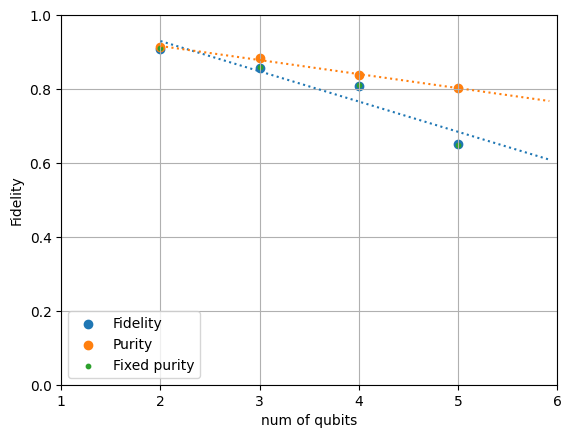

In [7]:
#Draw
plt.style.use('default')
plt.figure(dpi=100)
plt.scatter(fidelities.keys(), fidelities.values())
plt.scatter(purities.keys(), purities.values())
plt.scatter(purities.keys(), fixed_purities, alpha=1, s=10)
plt.axis([1, 6, 0, 1])
plt.ylabel('Fidelity')
plt.xlabel('num of qubits')
plt.legend(["Fidelity", "Purity", "Fixed purity"])
plt.grid(True)

print(fidelities)
print(purities)

x = np.linspace(2, 6, 50, False)
poly_f = np.polyfit(list(fidelities.keys()), list(fidelities.values()), 1)
poly_p = np.polyfit(list(purities.keys()), list(purities.values()), 1)
trendpoly_f = np.poly1d(poly_f)
trendpoly_p = np.poly1d(poly_p)
print(trendpoly_f)
print(trendpoly_p)
plt.plot(x, trendpoly_f(x), ':')
plt.plot(x, trendpoly_p(x), ':')
#plt.plot(fidelities)
plt.show()